# Descubra quem fez o ENEM 2016 apenas para treino

Neste desafio deverá descobrir quais estudantes estão fazendo a prova apenas para treino.

## Detalhes

O contexto do desafio gira em torno dos resultados do ENEM 2016 (disponíveis no arquivo train.csv). Este arquivo, e apenas ele, deve ser utilizado para todos os desafios. Qualquer dúvida a respeito das colunas, consulte o [Dicionário dos Microdados do Enem 2016](https://s3-us-west-1.amazonaws.com/acceleration-assets-highway/data-science/dicionario-de-dados.zip).

Alguns estudantes decidem realizar prova do ENEM de forma precoce, como um teste (coluna IN_TREINEIRO). Neste desafio, você deve criar um modelo de classificação binária para inferir a mesma. Os resultados possíveis da sua resposta devem ser “0” ou “1”.

Salve sua resposta em um arquivo chamado answer.csv com duas colunas: `NU_INSCRICAO` e `IN_TREINEIRO`.

In [1]:
#Importação de bibliotecas e pacotes
import pandas as pd
import numpy as np
import statsmodels.api as sm
import researchpy
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc

In [2]:
#Funções
def cria_df_aux(df):
    df_aux = pd.DataFrame({'Type': df.dtypes,
                          'Missing': df.isna().sum(),
                           'Size': df.shape[0],
                           'Unique': df.nunique()
                     })
    df_aux['Missing_%']= df_aux.Missing/df_aux.Size * 100
    df_aux
    return df_aux

def graph_ROC(prob, roc):
    pred = prob[:,1]
    fpr, tpr, threshold = roc
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [3]:
#Importanção dos bancos de dados
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [4]:
train.head(5)

,Unnamed: 0,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,...,Q041,Q042,Q043,Q044,Q045,Q046,Q047,Q048,Q049,Q050
0,1,ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,2016,4314902,Porto Alegre,43,RS,24,M,0.0,...,5.0,A,A,A,A,A,A,A,B,D
1,2,2c3acac4b33ec2b195d77e7c04a2d75727fad723,2016,2304707,Granja,23,CE,17,F,0.0,...,NaN,A,A,C,A,B,A,A,C,A
2,3,f4545f8ccb9ff5c8aad7d32951b3f251a26e6568,2016,2304400,Fortaleza,23,CE,21,F,0.0,...,NaN,A,A,A,A,C,A,A,B,A
3,4,3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe,2016,3304557,Rio de Janeiro,33,RJ,25,F,0.0,...,5.0,C,A,A,A,A,D,A,A,A
4,5,bf896ac8d3ecadd6dba1dfbf50110afcbf5d3268,2016,1302603,Manaus,13,AM,28,M,0.0,...,NaN,A,A,A,A,A,A,A,A,A


In [5]:
test.head(5)

,NU_INSCRICAO,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,...,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047
0,ba0cc30ba34e7a46764c09dfc38ed83d15828897,43,RS,19,F,1,1,1,3,1,...,NaN,NaN,E,E,H,B,B,C,D,A
1,177f281c68fa032aedbd842a745da68490926cd2,15,PA,24,M,3,2,1,4,1,...,NaN,NaN,B,C,B,A,A,C,D,A
2,6cf0d8b97597d7625cdedc7bdb6c0f052286c334,29,BA,16,F,2,1,3,0,1,...,NaN,NaN,E,F,G,B,B,A,NaN,D
3,5c356d810fa57671402502cd0933e5601a2ebf1e,41,PR,17,F,1,1,2,0,2,...,40.0,480.0,E,E,E,C,B,B,C,A
4,df47c07bd881c2db3f38c6048bf77c132ad0ceb3,53,DF,19,F,1,1,1,1,1,...,80.0,720.0,E,E,E,B,B,B,D,A


## Criação de base de treino

Nota-se que a base de test possui 43 colunas apenas, contra 167 da base de treino. Desta forma, faz sentido treinar o modelo apenas com os dados que ele irá receber para a previsão. Vamos analisar as colunas que há em comum em ambos.

In [6]:
columns_train = train.columns
columns_test = test.columns

common_columns = list(set(columns_test).intersection(columns_train))
len(common_columns)

43

Nota-se que todos as colunas da base test encontram-se na base train. Vamos passar a analisar quais colunas são essas, analisando sua relevância para o problema proposto.

In [7]:
common_columns.sort()
print(common_columns)

['CO_UF_RESIDENCIA', 'IN_BAIXA_VISAO', 'IN_CEGUEIRA', 'IN_DISCALCULIA', 'IN_DISLEXIA', 'IN_GESTANTE', 'IN_IDOSO', 'IN_SABATISTA', 'IN_SURDEZ', 'NU_IDADE', 'NU_INSCRICAO', 'NU_NOTA_CH', 'NU_NOTA_CN', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5', 'NU_NOTA_LC', 'NU_NOTA_REDACAO', 'Q001', 'Q002', 'Q006', 'Q024', 'Q025', 'Q026', 'Q027', 'Q047', 'SG_UF_RESIDENCIA', 'TP_ANO_CONCLUIU', 'TP_COR_RACA', 'TP_DEPENDENCIA_ADM_ESC', 'TP_ENSINO', 'TP_ESCOLA', 'TP_LINGUA', 'TP_NACIONALIDADE', 'TP_PRESENCA_CH', 'TP_PRESENCA_CN', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT', 'TP_SEXO', 'TP_STATUS_REDACAO', 'TP_ST_CONCLUSAO']


### Observações para a seleção prévia de variáveis

Notadamente devemos remover as colunas 'NU_INSCRICAO' e 'SG_UF_RESIDENCIA', pois a primeira apenas indica o número de inscrição do aluno e a segunda é a mesma coluna que 'CO_UF_RESIDENCIA', sendo essa já codificada.

In [8]:
features = common_columns
features.remove('NU_INSCRICAO')
features.remove('SG_UF_RESIDENCIA')

Outra coluna que me parece desnecessária é a coluna TP_STATUS_REDACAO, pois me parece que caso sua indicação seja diferente de 1 (redação sem problemas) a nota da redação será 0. Vamos verificar:

In [9]:
status_redacao = train.loc[:, ['TP_STATUS_REDACAO', 'NU_NOTA_REDACAO']]
status_redacao.query('TP_STATUS_REDACAO > 1 & NU_NOTA_REDACAO!="0"')

,TP_STATUS_REDACAO,NU_NOTA_REDACAO


Como ficou comprovado que caso o valor seja diferente de 1 em 'TP_STATUS_REDACAO' a nota da redação será 0, vamos remover também essa coluna.

In [10]:
features.remove('TP_STATUS_REDACAO')

Vamos continuar analisando os nossos dados para uma maior análise

In [11]:
#Dataframe auxiliar na análise
cria_df_aux(train[features])

,Type,Missing,Size,Unique,Missing_%
CO_UF_RESIDENCIA,int64,0,13730,27,0.000000
IN_BAIXA_VISAO,int64,0,13730,2,0.000000
IN_CEGUEIRA,int64,0,13730,1,0.000000
IN_DISCALCULIA,int64,0,13730,2,0.000000
IN_DISLEXIA,int64,0,13730,2,0.000000
IN_GESTANTE,int64,0,13730,2,0.000000
IN_IDOSO,int64,0,13730,2,0.000000
IN_SABATISTA,int64,0,13730,2,0.000000
IN_SURDEZ,int64,0,13730,2,0.000000
NU_IDADE,int64,0,13730,55,0.000000


### Mais algumas observações feitas nas variáveis selecionadas

Nota-se que a coluna 'IN_CEGUEIRA' indica que há só 1 item único em sua base, o que indica que não há alunos com cegueira no Enem 2016 e, portanto, deve ser uma coluna removida.

In [12]:
features.remove('IN_CEGUEIRA')

### Tratamento dados faltantes

A maior parte de variáveis que possuem dados faltantes são notas de provas, com exceção de 3 variáveis (TP_DEPENDENCIA_ADM_ESC, TP_ENSINO e Q027). Dessa forma, optei por substituir os dados faltantes por 0, por ser o correspondente ao valor recebido pelo aluno que não possui nota na prova

In [13]:
missing_data = ('NU_NOTA_CH','NU_NOTA_CN', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4',
                'NU_NOTA_COMP5', 'NU_NOTA_LC', 'NU_NOTA_REDACAO', 'TP_DEPENDENCIA_ADM_ESC', 'TP_ENSINO', 'Q027')

for i in missing_data:
    train[i].fillna(0, inplace = True)

train['NU_NOTA_MT'].fillna(0, inplace = True)

In [14]:
#Revendo o dataframe auxiliar na análise
cria_df_aux(train[features])

,Type,Missing,Size,Unique,Missing_%
CO_UF_RESIDENCIA,int64,0,13730,27,0.0
IN_BAIXA_VISAO,int64,0,13730,2,0.0
IN_DISCALCULIA,int64,0,13730,2,0.0
IN_DISLEXIA,int64,0,13730,2,0.0
IN_GESTANTE,int64,0,13730,2,0.0
IN_IDOSO,int64,0,13730,2,0.0
IN_SABATISTA,int64,0,13730,2,0.0
IN_SURDEZ,int64,0,13730,2,0.0
NU_IDADE,int64,0,13730,55,0.0
NU_NOTA_CH,float64,0,13730,2978,0.0


Farei o mesmo tratamento para a base test.

In [15]:
for i in missing_data:
    test[i].fillna(0, inplace = True)

In [16]:
#Dataframe auxiliar na análise da base test
cria_df_aux(test[features])

,Type,Missing,Size,Unique,Missing_%
CO_UF_RESIDENCIA,int64,0,4570,27,0.0
IN_BAIXA_VISAO,int64,0,4570,2,0.0
IN_DISCALCULIA,int64,0,4570,1,0.0
IN_DISLEXIA,int64,0,4570,2,0.0
IN_GESTANTE,int64,0,4570,2,0.0
IN_IDOSO,int64,0,4570,2,0.0
IN_SABATISTA,int64,0,4570,2,0.0
IN_SURDEZ,int64,0,4570,1,0.0
NU_IDADE,int64,0,4570,47,0.0
NU_NOTA_CH,float64,0,4570,1961,0.0


## Continuando a análise das variáveis para o modelo

Utilizaremos o método Backward stepwise selection(BSS), procurando remover as colunas que contribuem menos para o modelo de acordo com algumas métricas.

### Relação entre as variáveis numéricas e a classe (que no caso é categórica)

Para análise da relação entre variáveis categóricas e variáveis quantitativas não há um consenso sobre a melhor forma de fazê-la, pois a correlação de Pearson e de Spearman, por exemplo, mede se duas variáveis estão se "movendo" juntas, e em qual grau de mudança. Não se pode aplicar essa lógica a relação de variáveis categóricas com variáveis numéricas, pois o valor de uma variável categórica convertida em número ser mais alto que o outro não significa que o valor dele aumentou. 

Para isso vamos separar colunas categóricas de numéricas, eis que existem métodos mais apropriados para análise de correlação entre variáveis apenas numéricas e variáveis numéricas e categóricas. Importante notar que, apesar de algumas variáveis estarem listadas como dados numéricos, elas são essencialmente categóricas e se comportam como tal, e desta forma foram colocadas dentre as categóricas.

In [17]:
numerical_columns =['NU_IDADE', 'NU_NOTA_CH', 'NU_NOTA_CN', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2',
                    'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5', 'NU_NOTA_LC', 'NU_NOTA_REDACAO', 'NU_NOTA_MT']

categorical_columns = set(features) - set(numerical_columns)
categorical_columns = sorted(categorical_columns)
print(categorical_columns)

['CO_UF_RESIDENCIA', 'IN_BAIXA_VISAO', 'IN_DISCALCULIA', 'IN_DISLEXIA', 'IN_GESTANTE', 'IN_IDOSO', 'IN_SABATISTA', 'IN_SURDEZ', 'Q001', 'Q002', 'Q006', 'Q024', 'Q025', 'Q026', 'Q027', 'Q047', 'TP_ANO_CONCLUIU', 'TP_COR_RACA', 'TP_DEPENDENCIA_ADM_ESC', 'TP_ENSINO', 'TP_ESCOLA', 'TP_LINGUA', 'TP_NACIONALIDADE', 'TP_PRESENCA_CH', 'TP_PRESENCA_CN', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT', 'TP_SEXO', 'TP_ST_CONCLUSAO']


In [18]:
#Analisando OLS junto a dados numéricos
ols = sm.OLS(train['IN_TREINEIRO'], train[numerical_columns]).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           IN_TREINEIRO   R-squared (uncentered):                   0.126
Model:                            OLS   Adj. R-squared (uncentered):              0.125
Method:                 Least Squares   F-statistic:                              197.1
Date:                Mon, 08 Jun 2020   Prob (F-statistic):                        0.00
Time:                        12:54:21   Log-Likelihood:                         -4547.3
No. Observations:               13730   AIC:                                      9115.
Df Residuals:                   13720   BIC:                                      9190.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
NU_IDADE           -0.0007      0.000     -3.494      0.000      -0.001      -0.000
NU_NOTA_CH       1.857e-05   5.54e-05      0.335      0.737      -9e-05       0.000
NU_NOTA_CN          0.0002   5.74e-05      3.094      0.002    6.51e-05       0.000
NU_NOTA_COMP1       0.0009      0.000      4.672      0.000       0.001       0.001
NU_NOTA_COMP2       0.0002      0.000      0.933      0.351      -0.000       0.001
NU_NOTA_COMP3      -0.0005      0.000     -2.318      0.020      -0.001   -8.11e-05
NU_NOTA_COMP4      -0.0004      0.000     -1.762      0.078      -0.001    4.31e-05
NU_NOTA_COMP5      -0.0002      0.000     -2.304      0.021      -0.000   -3.61e-05
NU_NOTA_LC          0.0002   5.04e-05      3.111      0.002     5.8e-05       0.000
NU_NOTA_REDACAO -2.956e-05   2.24e-05     -1.320      0.187   -7.34e-05    1.43e-05
NU_NOTA_MT      -2.718e-05   4.03e-05     -0.674      0.500      -0.000    5.18e-05
==============================================================================
Omnibus:                     4958.654   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13132.921
Skew:                           2.040   Prob(JB):                         0.00
Kurtosis:                       5.511   Cond. No.                     1.63e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.26e-23. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Há uma baixa relação entre essas variáveis, mas vamos manter as que apresentaram melhor resultado.

In [19]:
numerical_columns.remove('NU_NOTA_CH')
numerical_columns.remove('NU_NOTA_COMP2')
numerical_columns.remove('NU_NOTA_REDACAO')
numerical_columns.remove('NU_NOTA_MT')

In [20]:
#Reanalisando OLS junto a dados numéricos
ols = sm.OLS(train['IN_TREINEIRO'], train[numerical_columns]).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           IN_TREINEIRO   R-squared (uncentered):                   0.126
Model:                            OLS   Adj. R-squared (uncentered):              0.125
Method:                 Least Squares   F-statistic:                              281.4
Date:                Mon, 08 Jun 2020   Prob (F-statistic):                        0.00
Time:                        12:54:28   Log-Likelihood:                         -4547.9
No. Observations:               13730   AIC:                                      9110.
Df Residuals:                   13723   BIC:                                      9163.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
NU_IDADE         -0.0007      0.000     -3.461      0.001      -0.001      -0.000
NU_NOTA_CN        0.0002   3.46e-05      5.391      0.000       0.000       0.000
NU_NOTA_COMP1     0.0009      0.000      4.571      0.000       0.001       0.001
NU_NOTA_COMP3    -0.0005      0.000     -2.412      0.016      -0.001   -8.55e-05
NU_NOTA_COMP4    -0.0004      0.000     -1.814      0.070      -0.001    3.14e-05
NU_NOTA_COMP5    -0.0003      0.000     -2.483      0.013      -0.000   -5.49e-05
NU_NOTA_LC        0.0001   4.03e-05      3.633      0.000    6.74e-05       0.000
==============================================================================
Omnibus:                     4959.392   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13137.149
Skew:                           2.040   Prob(JB):                         0.00
Kurtosis:                       5.512   Cond. No.                         57.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
numerical_columns.remove('NU_NOTA_COMP3')
numerical_columns.remove('NU_NOTA_COMP4')
numerical_columns.remove('NU_NOTA_COMP5')

In [22]:
#Reanalisando OLS junto a dados numéricos
ols = sm.OLS(train['IN_TREINEIRO'], train[numerical_columns]).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           IN_TREINEIRO   R-squared (uncentered):                   0.123
Model:                            OLS   Adj. R-squared (uncentered):              0.123
Method:                 Least Squares   F-statistic:                              481.1
Date:                Mon, 08 Jun 2020   Prob (F-statistic):                        0.00
Time:                        12:54:33   Log-Likelihood:                         -4568.0
No. Observations:               13730   AIC:                                      9144.
Df Residuals:                   13726   BIC:                                      9174.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
NU_IDADE         -0.0006      0.000     -2.944      0.003      -0.001      -0.000
NU_NOTA_CN        0.0002   3.45e-05      4.939      0.000       0.000       0.000
NU_NOTA_COMP1  8.596e-05      0.000      0.689      0.491      -0.000       0.000
NU_NOTA_LC        0.0001   4.02e-05      3.201      0.001    4.98e-05       0.000
==============================================================================
Omnibus:                     4983.420   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13255.955
Skew:                           2.049   Prob(JB):                         0.00
Kurtosis:                       5.526   Cond. No.                         43.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
numerical_columns.remove('NU_NOTA_COMP1')

In [24]:
#Reanalisando OLS junto a dados numéricos
ols = sm.OLS(train['IN_TREINEIRO'], train[numerical_columns]).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           IN_TREINEIRO   R-squared (uncentered):                   0.123
Model:                            OLS   Adj. R-squared (uncentered):              0.123
Method:                 Least Squares   F-statistic:                              641.3
Date:                Mon, 08 Jun 2020   Prob (F-statistic):                        0.00
Time:                        12:54:38   Log-Likelihood:                         -4568.2
No. Observations:               13730   AIC:                                      9142.
Df Residuals:                   13727   BIC:                                      9165.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
NU_IDADE      -0.0006      0.000     -2.975      0.003      -0.001      -0.000
NU_NOTA_CN     0.0002   3.42e-05      5.076      0.000       0.000       0.000
NU_NOTA_LC     0.0001   3.14e-05      4.640      0.000    8.42e-05       0.000
==============================================================================
Omnibus:                     4983.118   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13254.182
Skew:                           2.049   Prob(JB):                         0.00
Kurtosis:                       5.525   Cond. No.                         42.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Relação entre as variáveis categóricas e a variável dependente (que no caso é também categórica)

Para a análise da relação entre variáveis categóricas vamos utilizar o V de Cramer, que é um número entre 0 e 1 que indica o quão forte duas variáveis categóricas estão associadas.

In [60]:
for i in categorical_columns:
    crosstab, results = researchpy.crosstab(train['IN_TREINEIRO'], train[i], test= "g-test")
    print(i, results)

CO_UF_RESIDENCIA                             G-test   results
0  Log-likelihood ratio ( 26.0) =   500.6761
1                       p-value =     0.0000
2                    Cramer's V =     0.1910
IN_BAIXA_VISAO                            G-test  results
0  Log-likelihood ratio ( 1.0) =    4.7326
1                      p-value =    0.0296
2                 Cramer's phi =    0.0186
IN_DISCALCULIA                            G-test  results
0  Log-likelihood ratio ( 1.0) =    0.2782
1                      p-value =    0.5979
2                 Cramer's phi =    0.0045
IN_DISLEXIA                            G-test  results
0  Log-likelihood ratio ( 1.0) =    0.2782
1                      p-value =    0.5979
2                 Cramer's phi =    0.0045
IN_GESTANTE                            G-test  results
0  Log-likelihood ratio ( 1.0) =    3.6185
1                      p-value =    0.0571
2                 Cramer's phi =    0.0162
IN_IDOSO                            G-test  results
0  Log-li

### Melhores resultados apresentados (acima de 0.4)

    TP_ANO_CONCLUIU          G-test    results

0  Log-likelihood ratio ( 10.0) =   2539.4814

1                       p-value =      0.0000

2                    Cramer's V =      0.4301

    TP_ST_CONCLUSAO      G-test    results

0  Log-likelihood ratio ( 3.0) =   8133.7790

1                      p-value =      0.0000

2                   Cramer's V =      0.7697

In [25]:
categorical_columns = ['TP_ANO_CONCLUIU', 'TP_ST_CONCLUSAO']

In [26]:
features = categorical_columns +numerical_columns
print(features)

['TP_ANO_CONCLUIU', 'TP_ST_CONCLUSAO', 'NU_IDADE', 'NU_NOTA_CN', 'NU_NOTA_LC']


### Criando as bases de treino

In [27]:
X = train[features].values
y = train['IN_TREINEIRO'].values

In [28]:
data_test = test[features].values

### Balanceamento

Como estamos diante de um problema de classificação, vamos analisar o balanceamento de nossa variável dependente

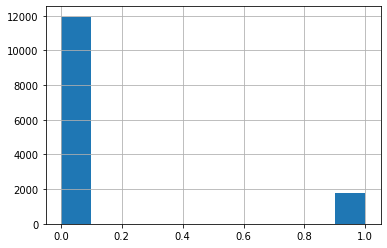

In [29]:
train['IN_TREINEIRO'].hist();

Observa-se um desbalanceamento da base, motivo pelo qual vamos fazer o balanceamento pelo método oversampling (Smote)

In [30]:
smote = SMOTE(sampling_strategy="minority")
X_smote, y_smote = smote.fit_resample(X, y)

In [31]:
#Dividindo os dados entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size = 0.3, random_state = 0)

## Comparando algoritimos de classificação

### Regressão logística

In [32]:
log_reg = LogisticRegression()

log_reg.fit(X_train,y_train)

print('Logistic Regression Score : ',log_reg.score(X_test,y_test))

Logistic Regression Score :  0.9881433951736643


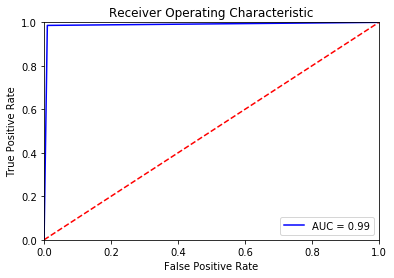

In [33]:
#Curva ROC (_Receiver Operating Curve_)
predict = log_reg.predict(X_test)
roc = roc_curve(y_test, predict)
prob = log_reg.predict_proba(X_test)
graph_ROC(prob, roc)

### K-Nearest Neighbors

In [34]:
knn = KNeighborsClassifier(n_neighbors = 3)

knn.fit(X_train,y_train)

print('K-Nearest Neighbors Score : ',knn.score(X_test,y_test))

K-Nearest Neighbors Score :  0.8921746408146185


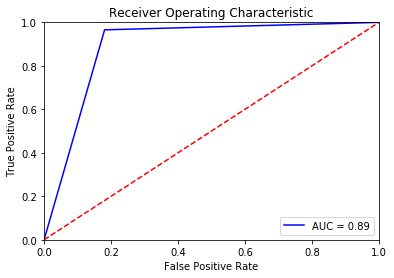

In [35]:
#Curva ROC (_Receiver Operating Curve_)
predict = knn.predict(X_test)
roc = roc_curve(y_test, predict)
prob = knn.predict_proba(X_test)
graph_ROC(prob, roc)

### Naive Bayes

In [36]:
nb = GaussianNB()

nb.fit(X_train,y_train)

print('Naive Bayes Score : ',nb.score(X_test,y_test))

Naive Bayes Score :  0.9850746268656716


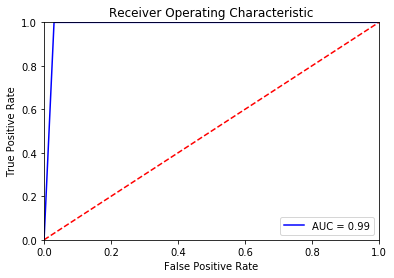

In [37]:
#Curva ROC (_Receiver Operating Curve_)
predict = nb.predict(X_test)
roc = roc_curve(y_test, predict)
prob = nb.predict_proba(X_test)
graph_ROC(prob, roc)

### Árvore de decisão

In [38]:
dt = DecisionTreeClassifier()

dt.fit(X_train,y_train)

print('Decision Tree Score : ',dt.score(X_test,y_test))

Decision Tree Score :  0.9948388896638304


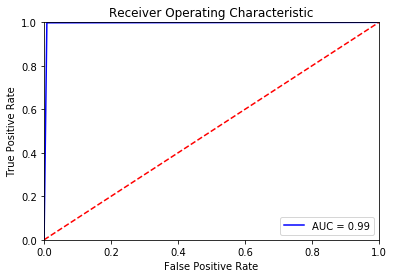

In [39]:
#Curva ROC (_Receiver Operating Curve_)
predict = dt.predict(X_test)
roc = roc_curve(y_test, predict)
prob = dt.predict_proba(X_test)
graph_ROC(prob, roc)

### Random Forest

In [40]:
rf = RandomForestClassifier(n_estimators = 22,random_state = 40)

rf.fit(X_train,y_train)

print('Random Forest Score : ',rf.score(X_test,y_test))

Random Forest Score :  0.9962337843492817


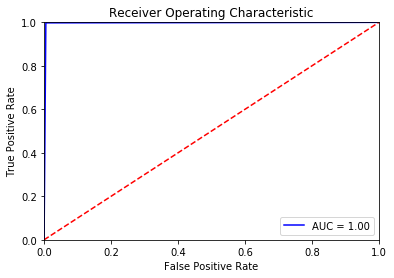

In [41]:
#Curva ROC (_Receiver Operating Curve_)
predict = rf.predict(X_test)
roc = roc_curve(y_test, predict)
prob = rf.predict_proba(X_test)
graph_ROC(prob, roc)

## Previsão final com Random Forest

In [42]:
#Pegando os resultados
data_test = test[features].values
result = []
rf.fit(X_smote, y_smote)
result = rf.predict(data_test)

In [43]:
#Pegando o número de inscrição
Inscricao = test.loc[:, 'NU_INSCRICAO'].values
Inscricao = Inscricao.reshape(-1, 1)

In [44]:
#Montando o arquivo csv de resposta
df1 = pd.DataFrame(data=result, columns=["IN_TREINEIRO"])  
df2 = pd.DataFrame(data=Inscricao, columns=["NU_INSCRICAO"])

answer = pd.concat([df2, df1], axis = 1)

answer.to_csv('answer.csv', index = False)

Result: 99.431072%